In [24]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

model = get_model_instance_segmentation(2)
model.load_state_dict(torch.load("R-CNNFineTuned_10000.pth"))



<All keys matched successfully>

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [26]:
import os
label_paths_test = os.listdir('C:/Users/bengu/Documents/TableOCR/DataSet/train/label')
images_fp = sorted([string.replace('mask_', 'C:/Users/bengu/Documents/TableOCR/TableBank.zip/TableBank/Detection/images/') for string in label_paths_test])
masks_fp = sorted([string.replace('C:/Users/bengu/Documents/TableOCR/TableBank.zip/TableBank/Detection/images/', 'C:/Users/bengu/Documents/TableOCR/DataSet/train/label/mask_') for string in images_fp])


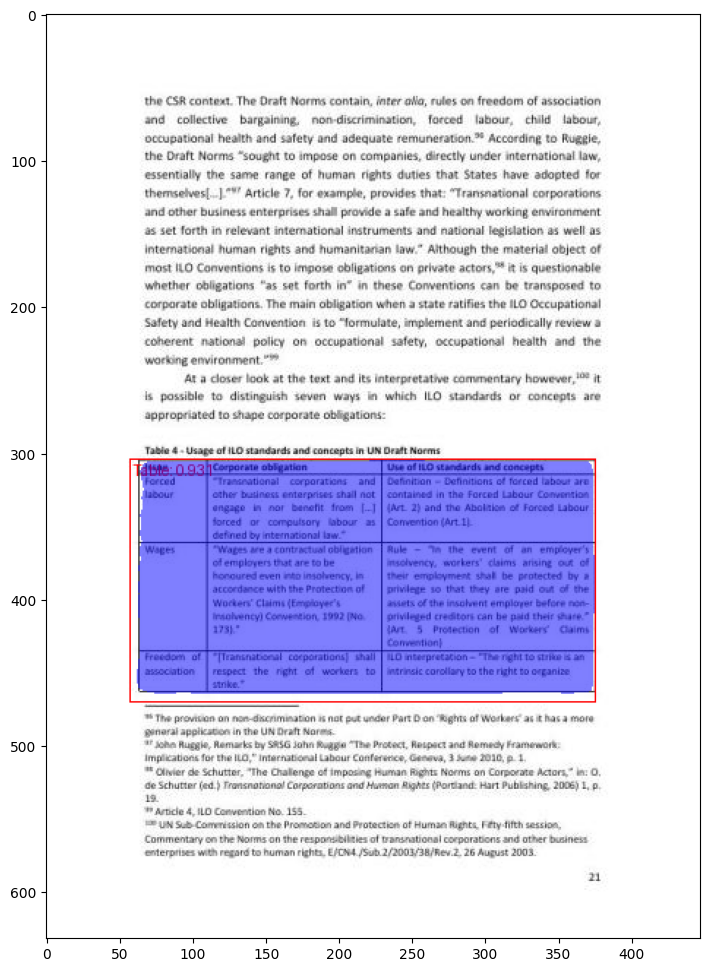

In [29]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import v2 as T
from torchvision.io import read_image
import torch

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)
image = read_image(images_fp[11300])
# image = read_image('C:/Users/bengu/Documents/TableOCR/TableBank.zip/TableBank/Detection/images/%5BMS-OXCFXICS%5D-080425_52_page1.jpg')
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Find the index of the bounding box with the highest score
max_score_index = torch.argmax(pred["scores"])

# Draw only the bounding box with the highest score
pred_labels = [f"Table: {pred['scores'][max_score_index]:.3f}"]
pred_boxes = pred["boxes"][max_score_index].long().unsqueeze(0)
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# Draw segmentation masks for all classes
masks = (pred["masks"] > 0.65).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


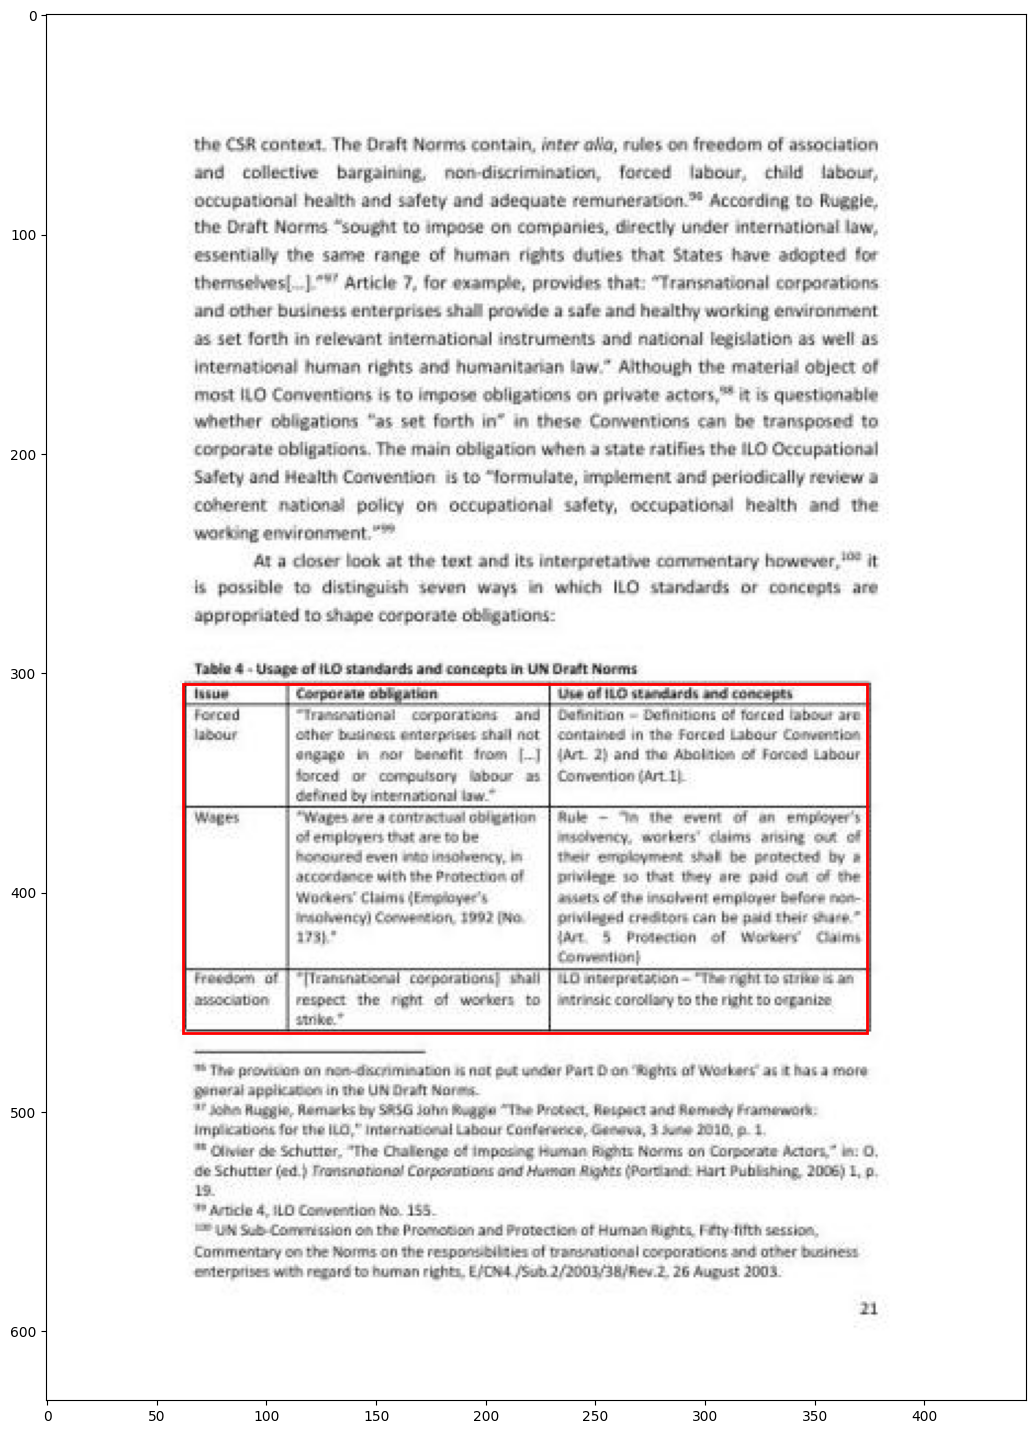

In [54]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

def find_bounding_box(mask):
    # Find non-zero indices (coordinates) in the mask
    non_zero_indices = torch.nonzero(mask, as_tuple=False)

    # Get the min and max coordinates
    y_min, x_min = torch.min(non_zero_indices, dim=0).values
    y_max, x_max = torch.max(non_zero_indices, dim=0).values

    return (x_min.item(), y_min.item()), (x_max.item(), y_max.item())

def draw_rectangle_and_return(image, mask, figsize=(12, 12)):
    # Find bounding box coordinates
    mask_min, mask_max = find_bounding_box(mask)

    # Extract coordinates
    x_min, y_min = mask_min
    x_max, y_max = mask_max

    # Calculate rectangle dimensions
    width = x_max - x_min
    height = y_max - y_min

    # Crop the region within the bounding box
    cropped_image = image[:, y_min:y_max, x_min:x_max]

    # Convert the image tensor to a PIL Image
    to_pil = ToPILImage()
    image_pil = to_pil(image.cpu()) if torch.is_tensor(image) else to_pil(image)

    # Create a new figure with the specified size
    fig, ax = plt.subplots(figsize=figsize)

    # Display the full image
    ax.imshow(image_pil)

    # Create a rectangle patch
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')

    # Add the rectangle patch to the plot
    ax.add_patch(rect)

    # Show the plot
    plt.show()

    # Return the cropped region
    return cropped_image

cropped_region = draw_rectangle_and_return(image, masks[0], figsize=(18, 18))


plt.show()

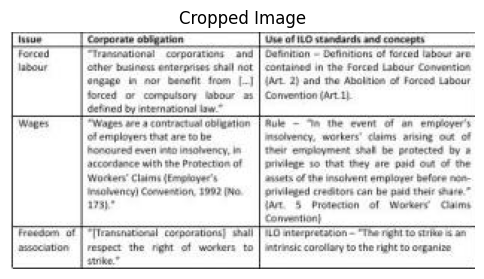

In [56]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Assuming 'cropped_region' is the tensor returned from the previous code
# If you named it differently, replace 'cropped_region' with your variable name

# Convert the cropped tensor to a numpy array
cropped_np = cropped_region.permute(1, 2, 0).cpu().numpy()

# Display the cropped image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cropped_np)
plt.title('Cropped Image')
plt.axis('off')
plt.show()
